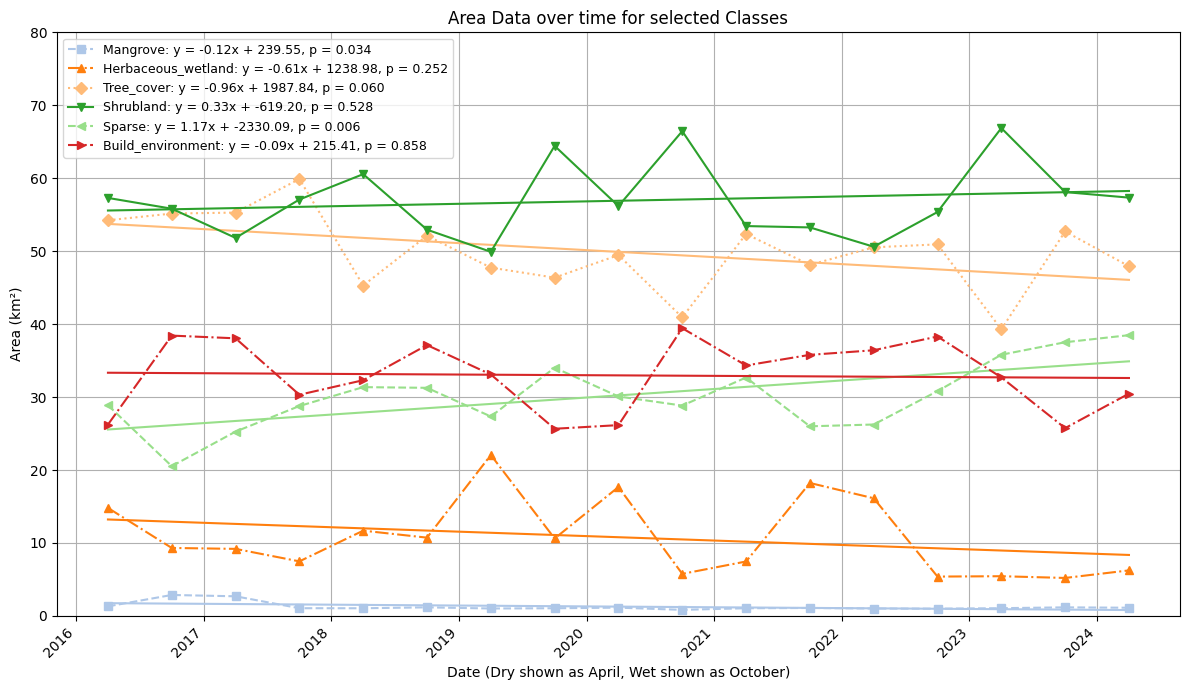

Area values exported to 'class_area_values.xlsx'


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import re
import ee
import pandas as pd
from scipy import stats
ee.Initialize()

# Load area data from file
classAreas = eval(open('./output/classAreas.txt', 'r').read())

# List assets from the specified folder
assets = ee.data.listAssets({'parent': 'projects/aruba-tdf/assets/1-images/'})

# Extract the image names (last part after '/')
image_names = [asset['id'].split('/')[-1] for asset in assets['assets']]

# Function to extract the year and type (wet/dry) from 'image_names' like '2024_dry'
def extract_year_and_type(name):
    match = re.match(r"(\d{4})_(\w+)", name)
    if match:
        year = int(match.group(1))
        type_ = match.group(2)
        # Treat 'dry' as April (month 4) and 'wet' as October (month 10)
        month = 4 if type_ == 'dry' else 10
        return year + (month - 1) / 12  # Convert year and month to a float
    return None

# Extract year and month for each image
year_months = [extract_year_and_type(name) for name in image_names]

# Convert year_months into the required format ('YYYY dry' or 'YYYY wet')
formatted_dates = [
    f"{int(year)} {'dry' if (year % 1) == 0.25 else 'wet'}"
    for year in year_months
]

# Initialize a DataFrame to store values for Excel export
df_export = pd.DataFrame({"Date": formatted_dates})

# Plotting with adjusted x labels
plt.figure(figsize=(12, 7))

# Color map and styles
color_map = plt.get_cmap('tab20').colors
line_styles = ['-', '--', '-.', ':']
markers = ['o', 's', '^', 'D', 'v', '<', '>', 'p', '*', '+', 'x', 'X', '|', '_', '.', ',', '1', '2']

# Loop through each class in classAreas and plot with regression line
for idx, (className, values) in enumerate(classAreas.items()):
    if className == 'Permanent_water':
        continue  
    else:
        # Convert area values to km²
        values_km2 = np.array(values) / 1000000

        # Add values to the DataFrame for export
        df_export[className] = np.round(values_km2, 2)
        
        # Plot the area data points
        ls = line_styles[idx % len(line_styles)]
        marker = markers[idx % len(markers)]

        # Perform linear regression using scipy's linregress (returns p-value)
        slope, intercept, r_value, p_value, std_err = stats.linregress(year_months, values_km2)
        
        # Generate the regression line based on the slope and intercept
        regression_line = slope * np.array(year_months) + intercept
        
        # Plot the regression line
        plt.plot(year_months, regression_line, color=color_map[idx], linestyle='-', linewidth=1.5)
        
        # Add the equation and p-value to the legend label
        equation_label = f"{className}: y = {slope:.2f}x + {intercept:.2f}, p = {p_value:.3f}"

        plt.plot(year_months, values_km2, label=equation_label, color=color_map[idx], linestyle=ls, marker=marker)

# Customize the plot
plt.xlabel('Date (Dry shown as April, Wet shown as October)')
plt.ylabel('Area (km²)')
plt.title('Area Data over time for selected Classes')
plt.legend(loc='best', fontsize=9)  # Update legend size and position
plt.grid(True)
plt.ylim(0,80)

# Rotate x-axis labels by 45 degrees for readability
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

# Export to Excel file with formatted date labels
df_export.to_excel('output/class_area_values.xlsx', index=False)
print("Area values exported to 'class_area_values.xlsx'")


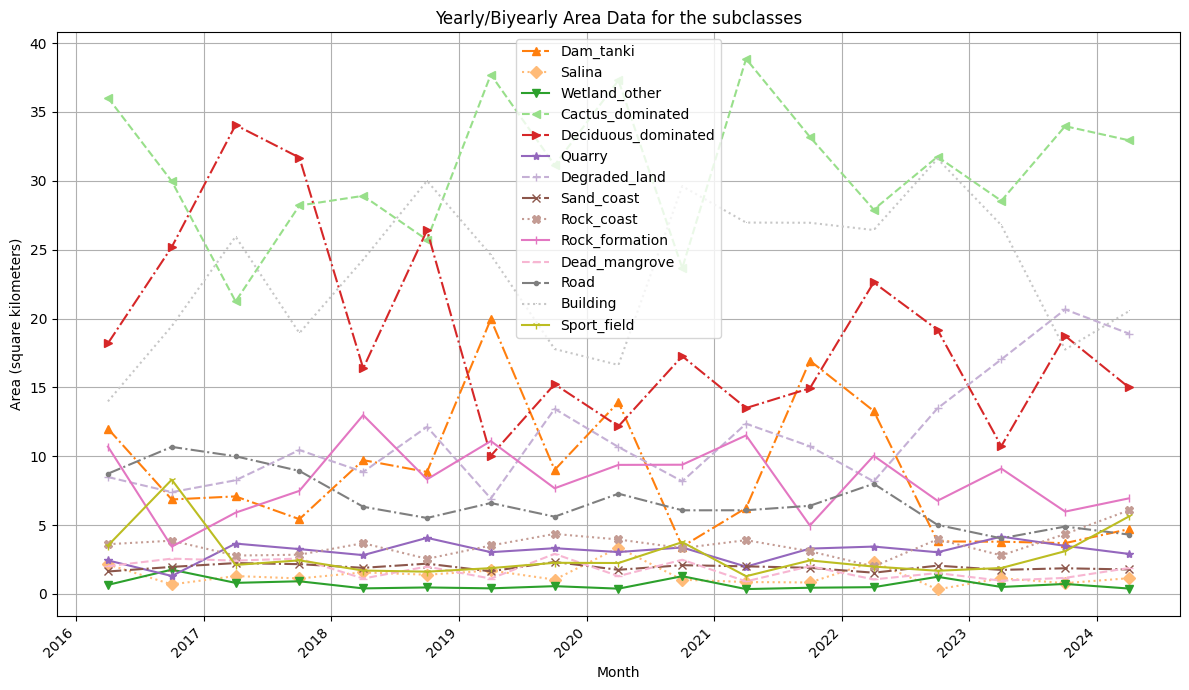

In [26]:
# show area of subclasses

import matplotlib.pyplot as plt

# Read the data
subClassAreas = eval(open('output/subClassAreas.txt', 'r').read())
year_months = [extract_year_and_type(name) for name in image_names]

# Convert areas from square meters to square kilometers
for subClass, areas in subClassAreas.items():
    subClassAreas[subClass] = [area / 1_000_000 for area in areas]

# Color map and styles
color_map = plt.get_cmap('tab20').colors
line_styles = ['-', '--', '-.', ':']
markers = ['o', 's', '^', 'D', 'v', '<', '>', 'p', '*', '+', 'x', 'X', '|', '_', '.', ',', '1', '2']

# Plotting with adjusted x labels
plt.figure(figsize=(12, 7))
for idx, (subClass, areas) in enumerate(subClassAreas.items()):
    if len(areas) > 0: 
        ls = line_styles[idx % len(line_styles)]
        marker = markers[idx % len(markers)]
        plt.plot(year_months, areas, label=subClass, color=color_map[idx], linestyle=ls, marker=marker)

plt.xticks(rotation=45, ha='right')
plt.xlabel('Month')
plt.ylabel('Area (square kilometers)')
plt.title('Yearly/Biyearly Area Data for the subclasses')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


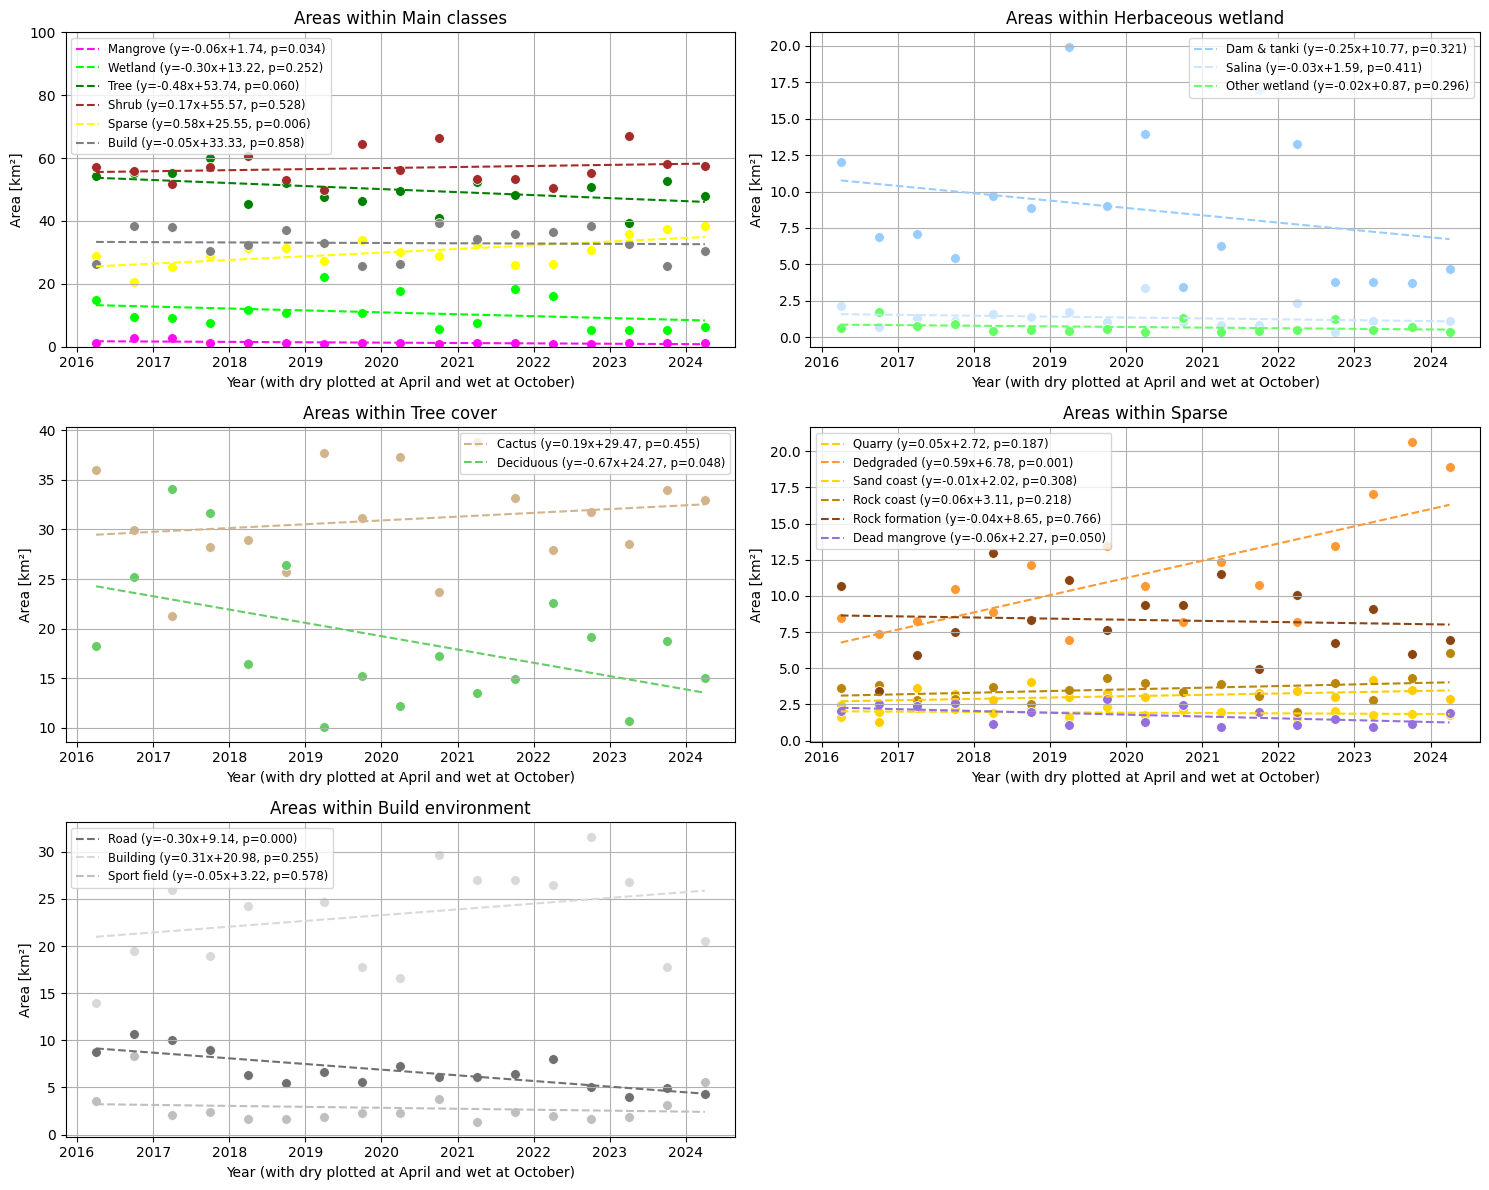

Area values exported to 'class_area_values.xlsx'


In [80]:
# Compute graphs for all areas
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
import seaborn as sns
import pandas as pd

classAreas = eval(open('output/classAreas.txt', 'r').read())
subClassAreas = eval(open('output/subClassAreas.txt', 'r').read())

# List assets from the specified folder
assets = ee.data.listAssets({'parent': 'projects/aruba-tdf/assets/1-images/'})

# Extract the image names (last part after '/')
image_names = [asset['id'].split('/')[-1] for asset in assets['assets']]

# create plotting var
year_months = [extract_year_and_type(name) for name in image_names]
 
# Convert areas from square meters to square kilometers
for mainClass, areas in classAreas.items():
    classAreas[mainClass] = [area / 1_000_000 for area in areas]

for subClass, areas in subClassAreas.items():
    subClassAreas[subClass] = [area / 1_000_000 for area in areas]

completeAreas = {'main': classAreas, 
                 'Herbaceous_wetland': {'Dam_tanki': subClassAreas['Dam_tanki'], 'Salina': subClassAreas['Salina'], 'Wetland_other': subClassAreas['Wetland_other']},
                 'Tree_cover': {'Cactus_dominated': subClassAreas['Cactus_dominated'], 'Deciduous_dominated': subClassAreas['Deciduous_dominated']},
                 'Sparse': {'Quarry': subClassAreas['Quarry'], 'Degraded_land': subClassAreas['Degraded_land'],'Sand_coast': subClassAreas['Sand_coast'],'Rock_coast': subClassAreas['Rock_coast'],'Rock_formation': subClassAreas['Rock_formation'],'Dead_mangrove': subClassAreas['Dead_mangrove']},
                 'Build_environment': {'Road': subClassAreas['Road'], 'Building': subClassAreas['Building'], 'Sport_field': subClassAreas['Sport_field']}
                 }

completeAreas['main'].pop('Permanent_water', None)  # Safely remove without raising an error if it doesn't exist

prettyClassNames = ['Mangrove', 'Wetland', 'Tree', 'Shrub', 'Sparse', 'Build']
prettySubClassNames = {'main': prettyClassNames,
                        'Herbaceous_wetland': ['Dam & tanki', 'Salina', 'Other wetland'], 
                        'Tree_cover': ['Cactus', 'Deciduous'], 
                        'Sparse': ['Quarry', 'Dedgraded', 'Sand coast', 'Rock coast', 'Rock formation', 'Dead mangrove'], 
                        'Build_environment': ['Road', 'Building', 'Sport field'] }
prettyProblemNames = ['Main classes', 'Herbaceous wetland', 'Tree cover', 'Sparse', 'Build environment']

colours = {'main': ['#ff0cf6', '#00FF00', '#008000', '#A52A2A', '#FFFF00', '#808080', '#000000'],
           'Herbaceous_wetland':  ['#99ccff', '#cce6ff', '#66ff66'],
            'Tree_cover': ['#d2b48c', '#66cc66'], 
            'Sparse': ['#ffcc00', '#ff9933', '#ffd700', '#b8860b', '#8b4513', '#9370db'],
            'Build_environment': ['#707070', '#d9d9d9', '#bfbfbf']
}

# Convert year_months into the required format ('YYYY dry' or 'YYYY wet')
formatted_dates = [
    f"{int(year)} {'dry' if (year % 1) == 0.25 else 'wet'}"
    for year in year_months
]

# Initialize a DataFrame to store values for Excel export
df_export = pd.DataFrame({"Date": formatted_dates})

# Plotting the timeseries data with regression lines
fig, axs = plt.subplots(3, 2, figsize=(15, 12))
axs = axs.flatten()

for idx, (problem, problemValues) in enumerate(completeAreas.items()):
    prettyProblem = prettyProblemNames[idx]
    for i, (className, timeseries) in enumerate(problemValues.items()):
        prettyClassName = prettySubClassNames[problem][i]
        colour = colours[problem][i]
        
        # Plot the time series
        sns.scatterplot(x=year_months, y=timeseries, ax=axs[idx], s=50, color=colour)
        
        # Compute linear regression
        x_vals = np.arange(len(timeseries))  # Numeric representation of year_months
        slope, intercept, r_value, p_value, std_err = linregress(x_vals, timeseries)
        
        # Plot the regression line
        regression_line = intercept + slope * x_vals
        axs[idx].plot(year_months, regression_line, '--', color=colour, label=f'{prettyClassName} (y={slope:.2f}x+{intercept:.2f}, p={p_value:.3f})')

        df_export[prettyClassName] = np.round(timeseries, 2)

    if idx == 0:
        axs[idx].set_ylim(0, 100)
    # Set labels and title
    axs[idx].set_xlabel('Year (with dry plotted at April and wet at October)')
    axs[idx].set_ylabel('Area [km²]')
    axs[idx].set_title(f'Areas within {prettyProblem}')
    axs[idx].legend(fontsize='small')
    axs[idx].grid(True)

# Remove the last subplot if there are fewer problems than subplots (empty space)
for i in range(len(completeAreas), len(axs)):
    fig.delaxes(axs[i])

# Adjust layout to avoid overlapping
plt.tight_layout()

# Show the combined plot with 5 subplots
plt.show()

# Export to Excel file with formatted date labels
df_export.to_excel('output/class_area_values.xlsx', index=False)
print("Area values exported to 'class_area_values.xlsx'")

In [100]:
# calculate SDG 15.1.1 
import datetime

crudeBorders = ee.Geometry.Polygon(
        [[[-70.07663362002641, 12.642409005331041],
          [-70.08350007510454, 12.528484055387077],
          [-69.95303742862016, 12.419873412682719],
          [-69.85416047549516, 12.389025068780875],
          [-69.84111421084673, 12.40109659488839],
          [-69.86240022158891, 12.486251996961656],
          [-70.05466096377641, 12.641069006200203]]])

# Function to calculate the area of a feature and return it only if 'landcover' equals 1 and area is greater than 200m2
def calculate_area(feature):
    # Calculate area in square meters
    area = feature.geometry().area(10)  # Compute area in square meters with 10 meters precision
    
    # Check if the area is greater than 5000 m² (as per SDG definition)
    is_area_greater_than_threshold = area.gt(5000)
    
    # Combine the two conditions (landcover == 1 and area > 5000 m²)
    return ee.Algorithms.If(
        is_area_greater_than_threshold,  # If both conditions are True
        feature.set('area', area),  # Return the feature with the area set
        feature.set('area', 0)  # Otherwise, return the feature with area 0
    )

# List assets from the specified folder
assets = ee.data.listAssets({'parent': 'projects/aruba-tdf/assets/1-images/'})

# Extract the image names (last part after '/')
image_names = [asset['id'].split('/')[-1] for asset in assets['assets']]


treeCoverAreas = {'Mangrove': [], 'Deciduous': [], 'Cactus': [], 'Forest': [], 'Tropical Dry Forest': []}

for name in image_names:
    res = 10
    classImage = ee.Image(f'projects/aruba-tdf/assets/2-mainClasses/{name}')
    subClassImage = ee.Image(f'projects/aruba-tdf/assets/3-subClasses/Tree_cover/{name}')
    
    maskedImage = classImage.updateMask(classImage.select('classification').eq(1))

    vector_image = maskedImage.addBands(classImage).reduceToVectors(
        geometry=crudeBorders,
        crs=classImage.projection(),
        scale=res,
        geometryType='polygon',
        eightConnected=True,
        labelProperty='landcover',
        reducer=ee.Reducer.mean()
    )

    areas = vector_image.map(calculate_area)
    total_area = areas.aggregate_sum('area')
    treeCoverAreas['Mangrove'].append(total_area.getInfo())

    # Then also for Decideous
    for i, subClass in enumerate(['Cactus', 'Deciduous']):
        maskedImage = subClassImage.updateMask(subClassImage.select('classification').eq(i))
        vector_image = maskedImage.addBands(subClassImage).reduceToVectors(
            geometry=crudeBorders,
            crs=subClassImage.projection(),
            scale=res,
            geometryType='polygon',
            eightConnected=True,
            labelProperty='landcover',
            reducer=ee.Reducer.mean()
        )
        areas = vector_image.map(calculate_area)
        total_area = areas.aggregate_sum('area')
        treeCoverAreas[subClass].append(total_area.getInfo())

    # print('vector : ', treeCoverAreas['Mangrove'][-1]/1_000_000, treeCoverAreas['Deciduous'][-1]/1_000_000)
    # print('regular : ', completeAreas['main']['Mangrove'][0], completeAreas['Tree_cover']['Deciduous_dominated'][0])
    treeCoverAreas['Forest'].append(treeCoverAreas['Deciduous'][-1] + treeCoverAreas['Mangrove'][-1])
    treeCoverAreas['Tropical Dry Forest'].append(treeCoverAreas['Deciduous'][-1] + treeCoverAreas['Cactus'][-1] + treeCoverAreas['Mangrove'][-1])

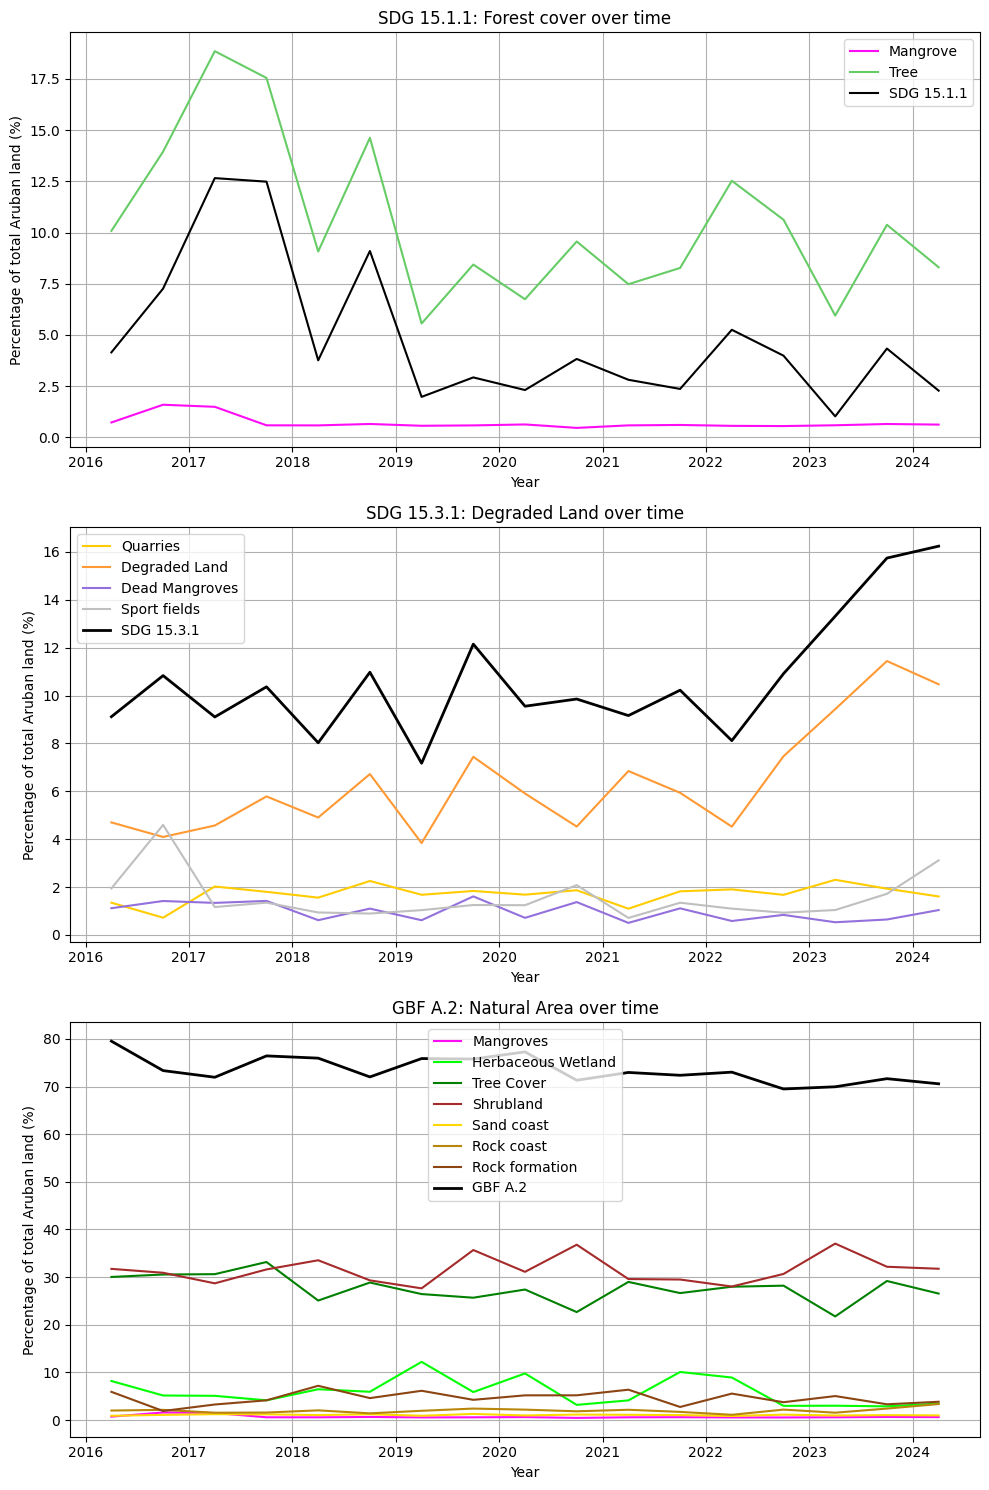

In [99]:
# show indicators

# plotting SDG 15.1.1
import numpy as np
arubanSize = 180.56

# Subplot configuration
fig, axs = plt.subplots(3, 1, figsize=(10, 15))

# Plot 1: SDG 15.1.1: Forest cover over time
axs[0].plot(year_months, np.array(completeAreas['main']['Mangrove'])/arubanSize*100, label='Mangrove', color=colours['main'][0])
axs[0].plot(year_months, np.array(completeAreas['Tree_cover']['Deciduous_dominated'])/arubanSize*100, label='Tree', color=colours['Tree_cover'][1])
axs[0].plot(year_months, (np.array(treeCoverAreas['Forest'])/1_000_000)/arubanSize*100, label='SDG 15.1.1', color='black')
axs[0].set_title('SDG 15.1.1: Forest cover over time')
axs[0].set_xlabel('Year')
axs[0].set_ylabel('Percentage of total Aruban land (%)')
axs[0].legend()
axs[0].grid(True)

# Plot 2: SDG 15.3.1: Degraded Land over time
quarriesAverages = np.array(subClassAreas['Quarry'])/arubanSize*100/1_000_000
degradAverages = np.array(subClassAreas['Degraded_land'])/arubanSize*100/1_000_000
deadMangroveAverages = np.array(subClassAreas['Dead_mangrove'])/arubanSize*100/1_000_000
sportfield = np.array(subClassAreas['Sport_field'])/arubanSize*100/1_000_000
degradedLand = quarriesAverages + degradAverages + deadMangroveAverages + sportfield

axs[1].plot(year_months, quarriesAverages, label='Quarries', color=colours['Sparse'][0])
axs[1].plot(year_months, degradAverages, label='Degraded Land', color=colours['Sparse'][1])
axs[1].plot(year_months, deadMangroveAverages, label='Dead Mangroves', color=colours['Sparse'][5])
axs[1].plot(year_months, sportfield, label='Sport fields', color=colours['Build_environment'][2])
axs[1].plot(year_months, degradedLand, label='SDG 15.3.1', linewidth=2, color='black')
axs[1].set_title('SDG 15.3.1: Degraded Land over time')
axs[1].set_xlabel('Year')
axs[1].set_ylabel('Percentage of total Aruban land (%)')
axs[1].legend()
axs[1].grid(True)

# Plot 3: GBF A.2: Natural Area over time
mangroveAverages = np.array(classAreas['Mangrove'])/arubanSize*100/1_000_000
herbaciousWetlandAverages = np.array(classAreas['Herbaceous_wetland'])/arubanSize*100/1_000_000
treeCoverAverages = np.array(classAreas['Tree_cover'])/arubanSize*100/1_000_000
shrublandAverages = np.array(classAreas['Shrubland'])/arubanSize*100/1_000_000
sandcoastAverages = np.array(subClassAreas['Sand_coast'])/arubanSize*100/1_000_000
rockycoastAverages = np.array(subClassAreas['Rock_coast'])/arubanSize*100/1_000_000
rockformationsAverages = np.array(subClassAreas['Rock_formation'])/arubanSize*100/1_000_000
naturalArea = (mangroveAverages + herbaciousWetlandAverages + treeCoverAverages + shrublandAverages + sandcoastAverages + rockycoastAverages + rockformationsAverages)

axs[2].plot(year_months, mangroveAverages, label='Mangroves', color=colours['main'][0])
axs[2].plot(year_months, herbaciousWetlandAverages, label='Herbaceous Wetland', color=colours['main'][1])
axs[2].plot(year_months, treeCoverAverages, label='Tree Cover', color=colours['main'][2])
axs[2].plot(year_months, shrublandAverages, label='Shrubland', color=colours['main'][3])
axs[2].plot(year_months, sandcoastAverages, label='Sand coast', color=colours['Sparse'][2])
axs[2].plot(year_months, rockycoastAverages, label='Rock coast', color=colours['Sparse'][3])
axs[2].plot(year_months, rockformationsAverages, label='Rock formation', color=colours['Sparse'][4])
axs[2].plot(year_months, naturalArea, label='GBF A.2', linewidth=2, color='black')
axs[2].set_title('GBF A.2: Natural Area over time')
axs[2].set_xlabel('Year')
axs[2].set_ylabel('Percentage of total Aruban land (%)')
axs[2].legend()
axs[2].grid(True)

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the combined plot
plt.show()


In [101]:
# give table of indicator values:
import pandas as pd
import datetime
dates = eval(open('./output/dates.txt', 'r').read())
dates = [date.year for date in dates]

sdg1511glob = (np.array(treeCoverAreas['Forest'])/1_000_000)/arubanSize*100
sdg1511loc = (np.array(treeCoverAreas['Tropical Dry Forest'])/1_000_000)/arubanSize*100
sdg1531 = degradedLand
bgfA2 = naturalArea

data = {
    'SDG 15.1.1 (international)': [round(indicator, 2) for indicator  in sdg1511glob], 
    'SDG 15.1.1 (local)': [round(indicator, 2) for indicator  in sdg1511loc],
    'SDG 15.3.1': [round(indicator, 2) for indicator  in sdg1531],
    'GBF A.2': [round(indicator, 2) for indicator  in bgfA2]
}

df = pd.DataFrame(data, index = formatted_dates)

output_file = './output/environmental_data.xlsx'
df.to_excel(output_file, sheet_name='Environmental Data')

          SDG 15.1.1 (international)  SDG 15.1.1 (local)  SDG 15.3.1  GBF A.2
2016 dry                        4.15               20.18        9.12    79.52
2016 wet                        7.26               19.54       10.83    73.34
2017 dry                       12.66               21.02        9.10    71.95
2017 wet                       12.48               22.12       10.36    76.43
2018 dry                        3.76               15.81        8.03    75.96
2018 wet                        9.10               18.18       10.97    72.02
2019 dry                        1.97               19.21        7.17    75.87
2019 wet                        2.92               16.18       12.15    75.77
2020 dry                        2.31               19.71        9.55    77.27
2020 wet                        3.83               13.22        9.85    71.32
2021 dry                        2.81               21.70        9.16    72.95
2021 wet                        2.36               16.31       1

Permanent_water 1084343
Mangrove 10520
Herbaceous_wetland 31168
Tree_cover 234722
Shrubland 333857
Sparse 116762
Build_environment 69450
Permanent_water 16
Mangrove 76
Herbaceous_wetland 6694
Tree_cover 109496
Shrubland 93055
Sparse 40926
Build_environment 29335
Permanent_water 68
Mangrove 615
Herbaceous_wetland 15255
Tree_cover 103790
Shrubland 112659
Sparse 130671
Build_environment 122047
Permanent_water 142
Mangrove 9
Herbaceous_wetland 231
Tree_cover 289
Shrubland 123
Sparse 1969
Build_environment 2004
Permanent_water 1029
Mangrove 143
Herbaceous_wetland 3810
Tree_cover 14904
Shrubland 17462
Sparse 32178
Build_environment 26081
Permanent_water 10
Mangrove 196
Herbaceous_wetland 4492
Tree_cover 29190
Shrubland 27496
Sparse 62606
Build_environment 57815
{'y0': [1.0, 1.0, 1.0, 1.0, 1.0, 0, 1.0], 'y1': [0.5765261146456178, 5.722501591570755e-05, 0.0001401758382205914, 0.029788126704426265, 0.010762810254479274, 0, 5.500398778911471e-05], 'y2': [0.005593299100074329, 0.00027181882559961

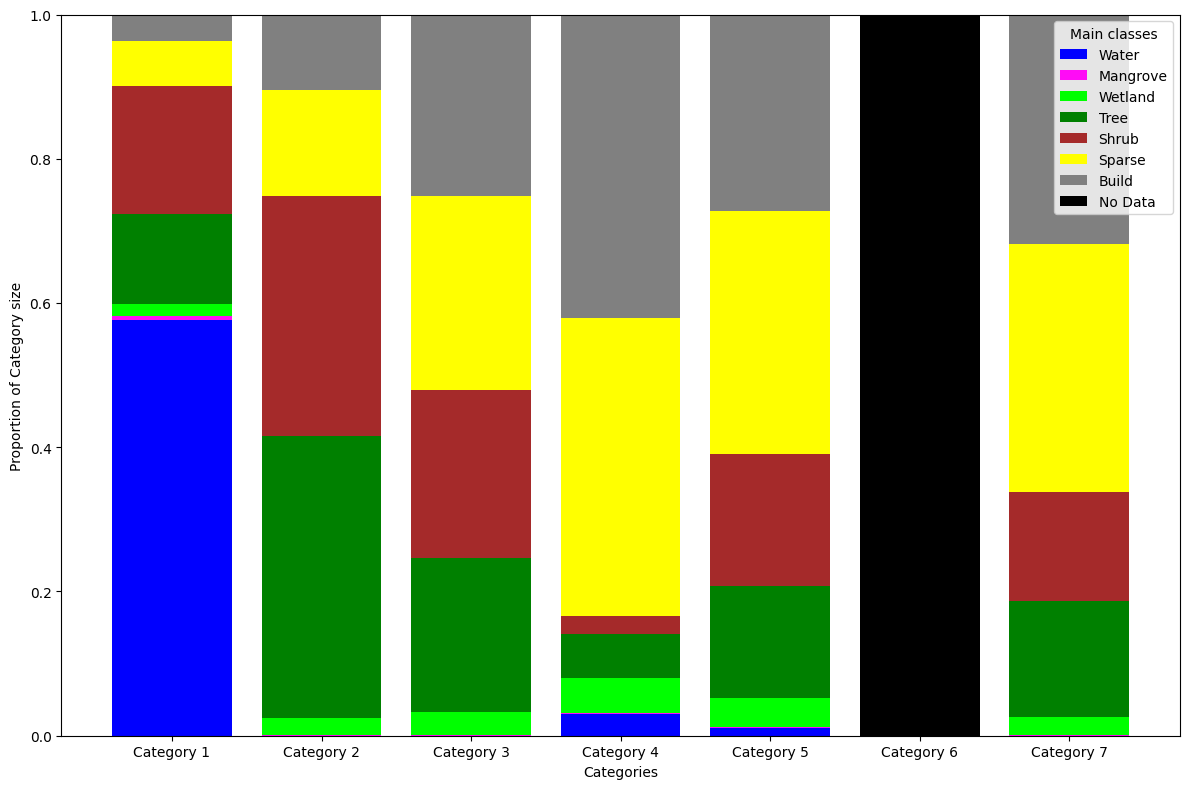

In [7]:
# Calculating values for Build with Nature policy
import geemap
m = geemap.core.Map()
ropv1 = ee.FeatureCollection('projects/ee-mooscastelijn/assets/ropv1')
ropv2 = ee.FeatureCollection('projects/ee-mooscastelijn/assets/ropv2')
ropv = ropv1.merge(ropv2)

ROPVCategories = [
    "Bedrijventerrein Barcadera",
    "Bedrijventerrein San Nicolas",
    "Centrum Oranjestad",
    "Centrum San Nicolas",
    "Havenfront Oranjestad",
    "Landelijk gebied",
    "Luchthaven",
    "Marine park",
    "Marinezones",
    "Natuur en landschap",
    "Natuurgebied",
    "Stedelijk woongebied",
    "Strand",
    "Toeristisch gebied westkust",
    "Toeristische zone oostkust",
    "Transformatiegebied",
    "Woongebied met waarden"
]

# Welke er missen uit het bijlage B: Industriegebied, Infrastructuur, Hoofdwegen, Oranjestad.
ROPVCatToFigure = {
    0: [10, 9, 12, 7, 8],
    1: [5],
    2: [16],
    3: [4, 13, 14],
    4: [6, 0, 1],
    5: [],
    6: [11, 2, 3, 15]
}

classNames = ['Permanent_water', 'Mangrove', 'Herbaceous_wetland', 'Tree_cover', 'Shrubland', 'Sparse', 'Build_environment']
prettyClassNames = ['Water', 'Mangrove', 'Wetland', 'Tree', 'Shrub', 'Sparse', 'Build']

# Segment names
segment_names = prettyClassNames + ['No Data']

classPalette = [
  '#0000FF', # Permanent Water: Blue
  '#ff0cf6', # Mangroves: Purple
  '#00FF00', # Herbaceous wetland: Bright Green
  '#008000', # Tree Cover: Dark Green
  '#A52A2A', # Shrubland: Brown
  '#FFFF00', # Bare or sparse vegetation: Yellow
  '#808080', # Built environment: Grey
  '#000000', # No data: Black 
]



imageDate = '2024_dry'
res = 10
classImage = ee.Image(f'projects/aruba-tdf/assets/2-mainClasses/{imageDate}')
ROPVRegionAreas = {region: [] for region in ROPVCatToFigure.keys()}

for ROPVZone, ROPVAreas in ROPVCatToFigure.items():
    legendaValues = [ROPVCategory for i, ROPVCategory in enumerate(ROPVCategories) if i in ROPVAreas]
    if len(legendaValues) > 0:
        filteredFeatures = ropv.filter(ee.Filter.inList('Legenda', legendaValues))
        mask = ee.Image.constant(1).clip(filteredFeatures.geometry())
        
        maskedToRegion = classImage.mask(mask)
        areaRegion = maskedToRegion.reduceRegion(reducer= ee.Reducer.count(), geometry= maskedToRegion.geometry(), scale= res)
        ROPVRegionAreas[ROPVZone].append(areaRegion.getInfo()['classification'])
        m.addLayer(maskedToRegion)

        for className in classNames:
            RegionToClassMasked = maskedToRegion.updateMask(maskedToRegion.select('classification').eq(classNames.index(className)))
            areaDict = RegionToClassMasked.reduceRegion(
                reducer=ee.Reducer.count(), geometry=RegionToClassMasked.geometry(), 
                scale=res, maxPixels=1e20)
            area = areaDict.getInfo()['classification']
            ROPVRegionAreas[ROPVZone].append(area)
            print(className, area)
    else:
        ROPVRegionAreas[ROPVZone].append(0)
        for className in classNames:
            ROPVRegionAreas[ROPVZone].append(0)

# Formatting labels
x = [
    f'Category 1', # \n Total area: \n {round(ROPVRegionAreas[0][0]*res**2/1000000, 2)} km²', 
    f'Category 2', # \n Total area: \n {round(ROPVRegionAreas[1][0]*res**2/1000000, 2)} km²', 
    f'Category 3', # \n Total area: \n {round(ROPVRegionAreas[2][0]*res**2/1000000, 2)} km²', 
    f'Category 4', # \n Total area: \n {round(ROPVRegionAreas[3][0]*res**2/1000000, 2)} km²', 
    f'Category 5', # \n Total area: \n {round(ROPVRegionAreas[4][0]*res**2/1000000, 2)} km²', 
    f'Category 6', # \n Total area: \n {0}',
    f'Category 7', # \n Total area: \n {round(ROPVRegionAreas[6][0]*res**2/1000000, 2)} km²'
]

# Normalize data based on the first value in each list
normalizedData = {}
for key, values in ROPVRegionAreas.items():
    if values[0] != 0:  # Avoid division by zero
        total = values[0]
        normalizedData[key] = [v / total for v in values]
    else:
        normalizedData[key] = [0 for v in values]

# Split normalized data for stacked bar plot
splitInYs = {f'y{i}': [] for i in range(len(ROPVRegionAreas[0]))}
for areaNumber, areas in normalizedData.items():
    for i, area in enumerate(areas):  # Include the first value (total area)
        splitInYs[f'y{i}'].append(area)

splitInYs['y8'] = [0, 0, 0, 0, 0, 1, 0]
print(splitInYs)

# Plot
fig, ax = plt.subplots(figsize=(12, 8))

# Stack the bars
bottom = np.zeros(len(x))
for i in range(1, len(ROPVRegionAreas[0])+1):  # Skip the first value (total area)
    ax.bar(x, splitInYs[f'y{i}'], bottom=bottom, label=segment_names[i-1], color=classPalette[i-1])
    bottom += splitInYs[f'y{i}']

# Add labels and title
ax.set_xlabel('Categories')
ax.set_ylabel('Proportion of Category size')
# ax.set_title(f'Land cover area division over Build with Nature categories')
ax.legend(title='Main classes')

plt.tight_layout()
plt.show()

In [146]:
# Build with nature data to table.
import pandas as pd
import numpy as np

# Extract partial areas (skipping the first element which is the total area for each category)
areas = {category: area_list[1:] for category, area_list in ROPVRegionAreas.items()}

# Extract total areas (first element of each area_list in ROPVRegionAreas)
total_areas = {category: area_list[0] for category, area_list in ROPVRegionAreas.items()}

display(splitInYs)
splitInYs.pop('y0', None)
splitInYs.pop('y8', None)
percentages = {
    i: list(np.round([el*100 for el in percList], 2)) for i, percList in enumerate(splitInYs.values())
}

df1 = pd.DataFrame.from_dict(percentages, orient='index')
df1.index = prettyClassNames
df1.columns = [f'Category {i}, [m²] (%)' for i in range(0, 7)]

df2 = pd.DataFrame(areas)
df2.index = prettyClassNames
df2.columns = [f'Category {i}, [m²] (%)' for i in range(0, 7)]

df = df2.astype(str) + ' (' + df1.astype(str) + ')'

output_file = './output/buildWithNature.xlsx'
df.to_excel(output_file, sheet_name='Environmental Data') 

{'y1': [0.5765261146456178,
  5.722501591570755e-05,
  0.0001401758382205914,
  0.029788126704426265,
  0.010762810254479274,
  0,
  5.500398778911471e-05],
 'y2': [0.005593299100074329,
  0.00027181882559961087,
  0.0012677667721421135,
  0.0018879798615481435,
  0.0014957063813319108,
  0,
  0.0010780781606666483],
 'y3': [0.016571477790030105,
  0.023941516033734147,
  0.03144680017728121,
  0.048458149779735685,
  0.03985063855157049,
  0,
  0.024707791314870328],
 'y4': [0.12479756191707668,
  0.3916193964191446,
  0.21395368013110563,
  0.060625131109712606,
  0.15588816718441117,
  0,
  0.16055664035642583],
 'y5': [0.17750589901649386,
  0.3328171160022604,
  0.23223631997196484,
  0.025802391441157962,
  0.18264353028543934,
  0,
  0.1512389648249498],
 'y6': [0.06208030318658544,
  0.14637443758539045,
  0.26936642582533676,
  0.4130480385986994,
  0.33656531425523234,
  0,
  0.34435796595253154],
 'y7': [0.036925344344121876,
  0.10491849011795507,
  0.2515888312839488,
  0.

In [ ]:
# # calculate SDG 15.1.1 Including local
import datetime

# Function to calculate the area of a feature and return it only if 'landcover' equals 1 and area is greater than 200m2
def calculate_area(feature):
    landcover = feature.get('landcover')
    # Check if landcover is 1. WHY?
    if ee.Number(landcover).eq(1):
        # Calculate area in square meters
        area = feature.geometry().area(10)  # Ensure area is in square meters
        # Check if the area is greater than 5000m2 as desired from sdg def
        if area.gt(5000):
            return ee.Feature(None, {'area': area})
    # Return a feature with area 0 if conditions are not met
    return ee.Feature(None, {'area': 0})


dates = eval(open('./output/dates.txt', 'r').read())
treeCoverAreas = {'Mangrove': [], 'Decideous': [], 'Cactus': [], 'Forest': [], 'Tropical Dry Forest': []}

for date in dates:
    formattedDate = date.strftime('%Y-%m')
    res = 30 
    classImage = ee.Image(f'projects/aruba-tdf/assets/classImages/{formattedDate}')
    subClassImage = ee.Image(f'projects/aruba-tdf/assets/subClassImages/{formattedDate}_Tree_Cover')
    
    # First calculate areas of Mangrove
    maskedImage = classImage.updateMask(classImage.select('classification').eq(1))
    vector_image = maskedImage.addBands(classImage).reduceToVectors(
        geometry=crudeBorders,
        crs=classImage.projection(),
        scale=res,
        geometryType='polygon',
        eightConnected=False,
        labelProperty='landcover',
        reducer=ee.Reducer.mean()
    )
    areas = vector_image.map(calculate_area)
    total_area = areas.aggregate_sum('area')
    treeCoverAreas['Mangrove'].append(total_area.getInfo())

    # Then also for Cactus and Decideous
    for i, subClass in enumerate(['Cactus','Decideous']):
        maskedImage = subClassImage.updateMask(subClassImage.select('classification').eq(i))
        vector_image = maskedImage.addBands(subClassImage).reduceToVectors(
            geometry=crudeBorders,
            crs=subClassImage.projection(),
            scale=res,
            geometryType='polygon',
            eightConnected=False,
            labelProperty='landcover',
            reducer=ee.Reducer.mean()
        )
        areas = vector_image.map(calculate_area)
        total_area = areas.aggregate_sum('area')
        treeCoverAreas[subClass].append(total_area.getInfo())
    
    treeCoverAreas['Forest'].append(treeCoverAreas['Decideous'][-1] + treeCoverAreas['Mangrove'][-1])
    treeCoverAreas['Tropical Dry Forest'].append(treeCoverAreas['Decideous'][-1] + treeCoverAreas['Cactus'][-1] + treeCoverAreas['Mangrove'][-1])

In [6]:
# Visualizing SDG 15.1.1
import geemap
m = geemap.core.Map()


crudeBorders = ee.Geometry.Polygon(
        [[[-70.07663362002641, 12.642409005331041],
          [-70.08350007510454, 12.528484055387077],
          [-69.95303742862016, 12.419873412682719],
          [-69.85416047549516, 12.389025068780875],
          [-69.84111421084673, 12.40109659488839],
          [-69.86240022158891, 12.486251996961656],
          [-70.05466096377641, 12.641069006200203]]])


imageDate = '2024_dry'
classImage = ee.Image(f'projects/aruba-tdf/assets/2-mainClasses/{imageDate}')
subClassImage = ee.Image(f'projects/aruba-tdf/assets/3-subClasses/Tree_cover/{imageDate}')

visM = {
    'color': '#ff0cf6'  # Pink color
}

visC = {'color': '#A52A2A' }

visT = {
    'color': '#013220'  # Dark green and red-brown
}

mangrove = classImage.updateMask(classImage.eq(1))
vMangrove = mangrove.addBands(mangrove).reduceToVectors(
            geometry=crudeBorders,
            crs=subClassImage.projection(),
            scale=10,
            geometryType='polygon',
            eightConnected=True,
            labelProperty='landcover',
            reducer=ee.Reducer.mean()
        )
vMangroveLargePolygons = vMangrove.map(lambda feature: feature.set({'area': feature.geometry().area(10)}))
vMangroveLargePolygons = vMangroveLargePolygons.filter(ee.Filter.gt('area', 5000))

cactus = subClassImage.updateMask(subClassImage.eq(0))
vCactus = cactus.addBands(cactus).reduceToVectors(
            geometry=crudeBorders,
            crs=subClassImage.projection(),
            scale=10,
            geometryType='polygon',
            eightConnected=True,
            labelProperty='landcover',
            reducer=ee.Reducer.mean()
        )
vCactusLargePolygons = vCactus.map(lambda feature: feature.set({'area': feature.geometry().area(10)}))
vCactusLargePolygons = vCactusLargePolygons.filter(ee.Filter.gt('area', 5000))

tree = subClassImage.updateMask(subClassImage.eq(1))
vTree = tree.addBands(tree).reduceToVectors(
            geometry=crudeBorders,
            crs=subClassImage.projection(),
            scale=10,
            geometryType='polygon',
            eightConnected=True,
            labelProperty='landcover',
            reducer=ee.Reducer.mean()
        )
vTreeLargePolygons = vTree.map(lambda feature: feature.set({'area': feature.geometry().area(10)}))
vTreeLargePolygons = vTreeLargePolygons.filter(ee.Filter.gt('area', 5000))

m.addLayer(vMangroveLargePolygons, visM, 'mangrove')
# m.addLayer(vCactusLargePolygons, visC, 'cactus')
m.addLayer(vTreeLargePolygons, visT, 'treeCover')
m.centerObject(vMangrove, 10)

m

Map(center=[12.49788277312402, -69.99764538160336], controls=(ZoomControl(options=['position', 'zoom_in_text',…

In [ ]:
# Visualizing SDG 15.3.1
imageDate = '2024-07'
buildImage = ee.Image(f'projects/aruba-tdf/assets/subClassImages/{imageDate}_Build_Environment')
bareImage = ee.Image(f'projects/aruba-tdf/assets/subClassImages/{imageDate}_Sparse')
m = geemap.Map()

# Subclasses: Quarry, Degraded_Land, Dead_Mangrove, Sportfields
quarry = bareImage.updateMask(bareImage.eq(0))
degrad = bareImage.updateMask(bareImage.eq(1))
dead = bareImage.updateMask(bareImage.eq(5))
sportfield = buildImage.updateMask(buildImage.eq(2))

vQuarry = quarry.addBands(quarry).reduceToVectors(
            geometry=crudeBorders,
            crs=bareImage.projection(),
            scale=30,
            geometryType='polygon',
            eightConnected=False,
            labelProperty='landcover',
            reducer=ee.Reducer.mean()
        )

vDegrad = degrad.addBands(degrad).reduceToVectors(
            geometry=crudeBorders,
            crs=bareImage.projection(),
            scale=30,
            geometryType='polygon',
            eightConnected=False,
            labelProperty='landcover',
            reducer=ee.Reducer.mean()
        )

vDead = dead.addBands(dead).reduceToVectors(
            geometry=crudeBorders,
            crs=bareImage.projection(),
            scale=30,
            geometryType='polygon',
            eightConnected=False,
            labelProperty='landcover',
            reducer=ee.Reducer.mean()
        )

vSportfield = sportfield.addBands(sportfield).reduceToVectors(
            geometry=crudeBorders,
            crs=bareImage.projection(),
            scale=30,
            geometryType='polygon',
            eightConnected=False,
            labelProperty='landcover',
            reducer=ee.Reducer.mean()
        )

visQ = {'color': '#595959' }
visDeg = {'color': 'brown'}
visDea = {'color': '#A9A9A9'}
visS= {'color': '#8B8000'}

m.addLayer(vQuarry, visQ, 'quarry')
m.addLayer(vDegrad, visDeg, 'Degraded')
m.addLayer(vDead, visDea, 'Dead mangrove')
m.addLayer(vSportfield, visS, 'Sportfield')
m.centerObject(bareImage, 10)
m